# Pedestrian Crash Analysis

# Import Modules

In [1]:
from dataset_reader import DatasetFromFiles, DatasetReaderCSV
from pathlib import Path
from dataset_preprocessor import DatasetPreprocessor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import src.utilities as utilities
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Export simulation datasets from csv

## Dataset Without timeseries
Reads all .txt files from a directory and creates a csv that is stored in a given directory.

In [2]:
path = Path("C:\\Users\geork\projects\AIThesis\datasets\\20240510\mlres")
out_path = Path("C:\\Users\geork\projects\AIThesis\src\\datasets\\crash_simulation_no_timeseries.csv")
r = DatasetFromFiles(path)
r.setOutputPath(out_path, True)
r.read()

Parsing simulation files: 100%|██████████| 1200/1200 [01:08<00:00, 17.43item/s]

Total read: 1200
With error: 0
Valid entries in csv: 1200
Finished... Results writtern in C:\Users\geork\projects\AIThesis\src\datasets\crash_simulation_no_timeseries.csv


## Dataset With timeseries
Works same as above, but with some more information, related to timeseries

In [3]:
path = Path("C:\\Users\geork\projects\AIThesis\datasets\\20240510\mlres")
out_path = Path("C:\\Users\geork\projects\AIThesis\src\\datasets\\crash_simulation_timeseries.csv")
r = DatasetFromFiles(path)
r.setTimeSeriesLabel("Head_X_Coordinate")
r.setTimeSeriesLabel("Head_Y_Coordinate")
r.setTimeSeriesLabel("Head_Z_Coordinate")
r.setTimeSeriesLabel("Sternum_X_Coordinate")
r.setTimeSeriesLabel("Sternum_Y_Coordinate")
r.setTimeSeriesLabel("Sternum_Z_Coordinate")
r.setOutputPath(out_path, True)
r.read()

Parsing simulation files: 100%|██████████| 1200/1200 [01:07<00:00, 17.83item/s]


Total read: 1200
With error: 14
Valid entries in csv: 1186
('C:\\Users\\geork\\projects\\AIThesis\\datasets\\20240510\\mlres\\Type=FCR_Vel=100_tra=0_rot=330_pos=initial.txt: '
 'Error while parsing: Missing values from Head_X_Coordinate')
('C:\\Users\\geork\\projects\\AIThesis\\datasets\\20240510\\mlres\\Type=FCR_Vel=100_tra=0_rot=330_pos=initial.txt: '
 'Error while parsing: Missing values from Head_Y_Coordinate')
('C:\\Users\\geork\\projects\\AIThesis\\datasets\\20240510\\mlres\\Type=FCR_Vel=100_tra=0_rot=330_pos=initial.txt: '
 'Error while parsing: Missing values from Head_Z_Coordinate')
('C:\\Users\\geork\\projects\\AIThesis\\datasets\\20240510\\mlres\\Type=FCR_Vel=100_tra=0_rot=330_pos=initial.txt: '
 'Error while parsing: Missing values from Sternum_X_Coordinate')
('C:\\Users\\geork\\projects\\AIThesis\\datasets\\20240510\\mlres\\Type=FCR_Vel=100_tra=0_rot=330_pos=initial.txt: '
 'Error while parsing: Missing values from Sternum_Y_Coordinate')
('C:\\Users\\geork\\projects\\AIThe

## Dataset with Accelerations

In [2]:
path = Path("C:\\Users\geork\projects\AIThesis\datasets\\20240510\mlres")
out_path = Path("C:\\Users\geork\projects\AIThesis\src\\datasets\\crash_accelerations.csv")
r = DatasetFromFiles(path)
r.setTimeSeriesLabel("Head_X_Acceleration")
r.setTimeSeriesLabel("Head_Y_Acceleration")
r.setTimeSeriesLabel("Head_Z_Acceleration")
r.setOutputPath(out_path, True)
r.read()

Parsing simulation files: 100%|██████████| 1200/1200 [01:58<00:00, 10.10item/s]


Total read: 1200
With error: 12
Valid entries in csv: 1188
('C:\\Users\\geork\\projects\\AIThesis\\datasets\\20240510\\mlres\\Type=FCR_Vel=100_tra=0_rot=330_pos=initial.txt: '
 'Error while parsing: Missing values from HISTORY 1 : Head_Z_Acceleration\n')
('C:\\Users\\geork\\projects\\AIThesis\\datasets\\20240510\\mlres\\Type=FCR_Vel=100_tra=0_rot=330_pos=initial.txt: '
 'Error while parsing: Missing values from HISTORY 1 : Head_Z_Acceleration\n')
('C:\\Users\\geork\\projects\\AIThesis\\datasets\\20240510\\mlres\\Type=FCR_Vel=100_tra=0_rot=330_pos=initial.txt: '
 'Error while parsing: Missing values from HISTORY 1 : Head_Z_Acceleration\n')
('C:\\Users\\geork\\projects\\AIThesis\\datasets\\20240510\\mlres\\Type=FCR_Vel=100_tra=200_rot=330_pos=initial.txt: '
 'Error while parsing: Missing values from HISTORY 1 : Head_Z_Acceleration\n')
('C:\\Users\\geork\\projects\\AIThesis\\datasets\\20240510\\mlres\\Type=FCR_Vel=100_tra=200_rot=330_pos=initial.txt: '
 'Error while parsing: Missing value

# Find crash time step

In [ ]:
path = Path("C:\\Users\geork\projects\AIThesis\src\datasets\crash_accelerations.csv")
reader = DatasetReaderCSV(path)
reader.read()
df_accelerations = reader.convert_to_dataframe()

In [ ]:
# Vazo se ena dataset ta entrie spou einai ligotera apo 301 sto timeseries. Einai mono 11.
# Function to check the length of the list
def has_less_than_301_entries(accel_str_x, accel_str_y, accel_str_z):
    try:
        accel_list_x = eval(accel_str_x)
        accel_list_y = eval(accel_str_y)
        accel_list_z = eval(accel_str_z)
    except Exception as e:
        return True
    return len(accel_list_x) < 301 or len(accel_list_y) < 301 or len(accel_list_z) < 301


df_less_than_301 = df_accelerations[
    df_accelerations.apply(
        lambda row: has_less_than_301_entries(
            row['Head_X_Acceleration'], 
            row['Head_Y_Acceleration'], 
            row['Head_Z_Acceleration']
        ), 
        axis=1
    )
]
# Optional: Reset index for the new DataFrame
df_less_than_301 = df_less_than_301.reset_index(drop=True)

# Print the new DataFrame or save it if necessary
print(df_less_than_301)

In [ ]:
ids_to_remove = df_less_than_301['Id'].unique()

# Drop rows with these Ids from the original DataFrame
df_accelerations_cleaned = df_accelerations[~df_accelerations['Id'].isin(ids_to_remove)]

# Optional: Reset index for the cleaned DataFrame
df_accelerations_cleaned = df_accelerations_cleaned.reset_index(drop=True)

# Print the cleaned DataFrame or save it if necessary
print("Cleaned DataFrame:")
print(df_accelerations_cleaned)

In [ ]:



#utilities.to_scrollable_table(df_accelerations.drop(columns=["Position"], errors="ignore"))
#print(df_accelerations.head)
# Function to calculate the magnitude of acceleration
def calculate_magnitude(accel_x, accel_y, accel_z, row):
    # Convert string representation of lists to actual listsprint
    if type(accel_x) != str:
        print(type(accel_x))
        print(accel_x)
        print(row["Path"])
        print(row)

    accel_x = np.array(eval(accel_x))
    accel_y = np.array(eval(accel_y))
    accel_z = np.array(eval(accel_z))
    
    # Calculate the magnitude of acceleration at each point
    magnitude = np.sqrt(accel_x**2 + accel_y**2 + accel_z**2)
    return magnitude

# Apply the function to each row
df_accelerations_cleaned['Acceleration_Magnitude'] = df_accelerations_cleaned.apply(
    lambda row: calculate_magnitude(row['Head_X_Acceleration'], row['Head_Y_Acceleration'], row['Head_Z_Acceleration'], row),
    axis=1
)

# Plot the acceleration magnitude and save as PNG
for index, row in df_accelerations_cleaned.iterrows():
    plt.figure()
    plt.plot(row['Acceleration_Magnitude'])
    plt.xlabel('Time (ms)')
    plt.ylabel('Acceleration Magnitude (m/s^2)')
    plt.title(f'Acceleration Magnitude for Entry {index}')
    plt.savefig(f'acceleration_plot_{index}.png')
    plt.close()
    break


# Convert csv file to Dataframe

In [5]:
path = Path("C:\\Users\geork\projects\AIThesis\src\datasets\crash_simulation_no_timeseries.csv")
reader = DatasetReaderCSV(path)
reader.read()
df = reader.convert_to_dataframe()

## Remove Redundant columns

In [6]:
df = df.drop(columns=["Position"], errors="ignore")

## Group HIC15_max value to bins

In [7]:
number_of_bins = 8

# Create quantile bins
y_binned, bin_edges = pd.qcut(df['HIC15_max'], q=number_of_bins, labels=[f'Q{i+1}' for i in range(number_of_bins)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Add the binned variable as a new column to the DataFrame
df['HIC15_max_binned'] = y_binned

# Now dfn_regr has the binned column
print(df.head())

# Print the count of each distinct value of HIC15_max_binned
print("\nCount of each distinct value of HIC15_max_binned:")
print(df['HIC15_max_binned'].value_counts().sort_index())

Ranges for each quantile bin:
Q1: 0.0 to 113.893625
Q2: 113.893625 to 444.45125
Q3: 444.45125 to 988.397375
Q4: 988.397375 to 1826.8964999999998
Q5: 1826.8964999999998 to 3490.965375
Q6: 3490.965375 to 7791.7429999999995
Q7: 7791.7429999999995 to 19452.69675
Q8: 19452.69675 to 277304.682
   Id                                               Path CarProfile  Velocity  \
0   0  C:\Users\geork\projects\AIThesis\datasets\2024...        FCR       100   
1   1  C:\Users\geork\projects\AIThesis\datasets\2024...        FCR       100   
2   2  C:\Users\geork\projects\AIThesis\datasets\2024...        FCR       100   
3   3  C:\Users\geork\projects\AIThesis\datasets\2024...        FCR       100   
4   4  C:\Users\geork\projects\AIThesis\datasets\2024...        FCR       100   

   Translation  Rotation  HIC15_max  HIC36_max  Head_Z_Acceleration_abs_max  \
0         -200         0     86.843    136.373                       36.081   
1         -200       120   2361.697   2866.369                    

## Expand Car Profiles

In [8]:
# Create the DataFrame
data = {
    'Front_Height': [770, 715, 880, 935],
    'Hood_Front_Width': [1160, 1080, 1100, 1388],
    'Hood_Back_Width': [1460, 1440, 1460, 1520],
    'Hood_Length': [1070, 1140, 870, 1105],
    'Hood_Angle': [11, 10, 12.3, 10],
    'Windscreen_Length': [816, 801, 930, 900],
    'Windscreen_Angle': [30, 27, 30, 31]
}

# New DataFrame with additional columns based on 'CarProfile'
index_labels = ['FCR', 'RDS', 'MPV', 'SUV']
temp_df = pd.DataFrame(data, index=index_labels)

# Map the new columns to original_df based on 'CarProfile'
for col in temp_df.columns:
    df[col] = df['CarProfile'].map(temp_df[col])

# Drop the 'CarProfile' column
# df = df.drop(columns=['CarProfile'])

print(df.head())


   Id                                               Path CarProfile  Velocity  \
0   0  C:\Users\geork\projects\AIThesis\datasets\2024...        FCR       100   
1   1  C:\Users\geork\projects\AIThesis\datasets\2024...        FCR       100   
2   2  C:\Users\geork\projects\AIThesis\datasets\2024...        FCR       100   
3   3  C:\Users\geork\projects\AIThesis\datasets\2024...        FCR       100   
4   4  C:\Users\geork\projects\AIThesis\datasets\2024...        FCR       100   

   Translation  Rotation  HIC15_max  HIC36_max  Head_Z_Acceleration_abs_max  \
0         -200         0     86.843    136.373                       36.081   
1         -200       120   2361.697   2866.369                      103.348   
2         -200       150    573.455    573.455                       74.161   
3         -200       180     84.702    153.528                       35.330   
4         -200       210    592.965    592.965                       42.322   

   Head_X_Acceleration_abs_max  ...  C

# Dataset Analysis

In [9]:
# Count missing values in each column
missing_values_count = df.isnull().sum()
print(missing_values_count)

Id                                          0
Path                                        0
CarProfile                                  0
Velocity                                    0
Translation                                 0
Rotation                                    0
HIC15_max                                   0
HIC36_max                                   0
Head_Z_Acceleration_abs_max                 0
Head_X_Acceleration_abs_max                 0
Head_Y_Acceleration_abs_max                 0
BrIC_abs_max                                0
Chest_Resultant_Acceleration_max            0
Chest_Resultant_Acceleration_CLIP3ms_max    0
HIC15_max_binned                            0
Front_Height                                0
Hood_Front_Width                            0
Hood_Back_Width                             0
Hood_Length                                 0
Hood_Angle                                  0
Windscreen_Length                           0
Windscreen_Angle                  

## Dataset Overview

In [10]:
# Exclude the 'Position' column from the DataFrame
utilities.to_scrollable_table(df.drop(columns=["Position"], errors="ignore"))

Id,Path,CarProfile,Velocity,Translation,Rotation,HIC15_max,HIC36_max,Head_Z_Acceleration_abs_max,Head_X_Acceleration_abs_max,Head_Y_Acceleration_abs_max,BrIC_abs_max,Chest_Resultant_Acceleration_max,Chest_Resultant_Acceleration_CLIP3ms_max,HIC15_max_binned,Front_Height,Hood_Front_Width,Hood_Back_Width,Hood_Length,Hood_Angle,Windscreen_Length,Windscreen_Angle
0,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=0_pos=initial.txt,FCR,100,-200,0,86.843,136.373,36.081,7.578,17.539,0.920,34.882,28.117,Q1,770,1160,1460,1070,11.0,816,30
1,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=120_pos=initial.txt,FCR,100,-200,120,2361.697,2866.369,103.348,179.802,54.333,1.718,36.302,19.450,Q5,770,1160,1460,1070,11.0,816,30
2,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=150_pos=initial.txt,FCR,100,-200,150,573.455,573.455,74.161,77.655,72.795,0.936,24.091,19.183,Q3,770,1160,1460,1070,11.0,816,30
3,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=180_pos=initial.txt,FCR,100,-200,180,84.702,153.528,35.330,13.216,13.956,0.905,49.501,28.255,Q1,770,1160,1460,1070,11.0,816,30
4,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=210_pos=initial.txt,FCR,100,-200,210,592.965,592.965,42.322,138.277,19.926,0.965,25.420,18.131,Q3,770,1160,1460,1070,11.0,816,30
5,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=240_pos=initial.txt,FCR,100,-200,240,1235.194,1235.194,65.935,136.515,38.005,1.127,40.085,30.059,Q4,770,1160,1460,1070,11.0,816,30
6,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=270_pos=initial.txt,FCR,100,-200,270,6257.955,6257.955,141.311,391.280,11.465,1.543,69.245,35.402,Q6,770,1160,1460,1070,11.0,816,30
7,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=300_pos=initial.txt,FCR,100,-200,300,4974.677,4974.677,100.702,453.532,31.697,1.193,50.792,43.538,Q6,770,1160,1460,1070,11.0,816,30
8,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=30_pos=initial.txt,FCR,100,-200,30,775.362,775.362,58.451,119.153,65.954,0.929,25.538,18.412,Q3,770,1160,1460,1070,11.0,816,30
9,C:\Users\geork\projects\AIThesis\datasets\20240510\mlres\Type=FCR_Vel=100_tra=-200_rot=330_pos=initial.txt,FCR,100,-200,330,440.203,440.203,37.944,104.015,34.352,1.176,24.579,18.154,Q2,770,1160,1460,1070,11.0,816,30


## Dataframe description

In [11]:
summary_stats = df.describe()
print(summary_stats)

                Id     Velocity  Translation     Rotation      HIC15_max  \
count  1200.000000  1200.000000  1200.000000  1200.000000    1200.000000   
mean    599.500000    60.000000     0.000000   165.000000   10594.607520   
std     346.554469    28.296064   282.960637   103.604754   28156.535615   
min       0.000000    20.000000  -400.000000     0.000000       0.000000   
25%     299.750000    40.000000  -200.000000    82.500000     444.451250   
50%     599.500000    60.000000     0.000000   165.000000    1826.896500   
75%     899.250000    80.000000   200.000000   247.500000    7791.743000   
max    1199.000000   100.000000   400.000000   330.000000  277304.682000   

           HIC36_max  Head_Z_Acceleration_abs_max  \
count    1200.000000                  1200.000000   
mean    10652.672504                   180.719489   
std     28139.017094                   282.624541   
min         0.000000                     0.000000   
25%       452.599750                    45.476000 

### Car Attributes: Profiles - Velocities

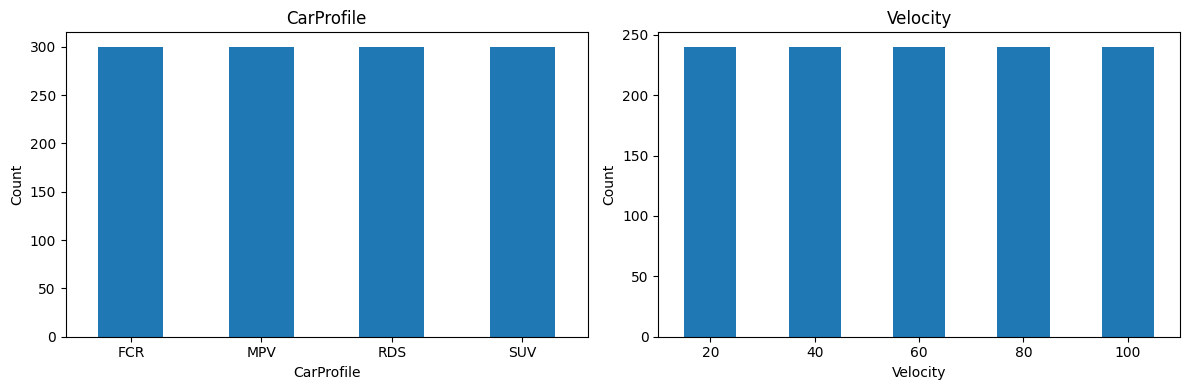

In [12]:
# Count the occurrences of each unique value in the 'Rotation' column and sort by label
counts_translation = df['CarProfile'].value_counts().sort_index()
counts_position = df["Velocity"].value_counts().sort_index()

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first bar chart
counts_translation.plot(kind='bar', ax=ax1)
ax1.set_title('CarProfile')
ax1.set_xlabel('CarProfile')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)  # Rotate x labels for better readability

# Plot the second bar chart
counts_position.plot(kind='bar', ax=ax2)
ax2.set_title('Velocity')
ax2.set_xlabel('Velocity')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=0)  # Rotate x labels for better readability

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

### Pedestration Attributes: Translation - Rotation

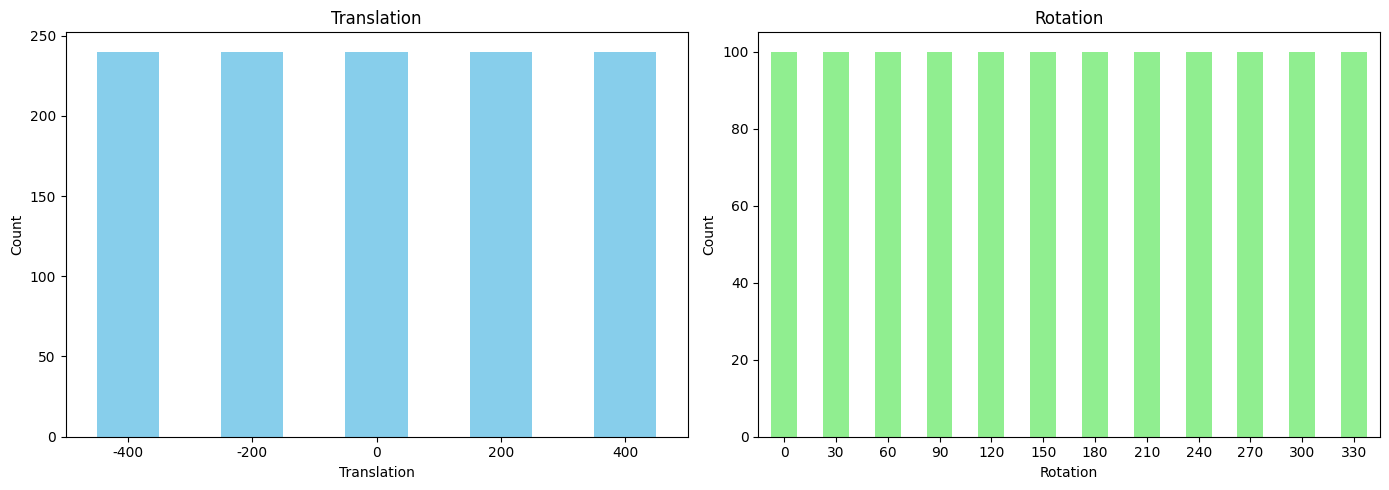

In [14]:
# Convert rotation labels to integers if they are not already
df['Translation'] = df['Translation'].astype(int)
df["Rotation"] = df["Rotation"].astype(int)
    
# Count the occurrences of each unique value in the 'Rotation' column and sort by label
counts_translation = df['Translation'].value_counts().sort_index()
counts_position = df["Rotation"].value_counts().sort_index()

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the first bar chart
counts_translation.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Translation')
ax1.set_xlabel('Translation')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)  # Rotate x labels for better readability

# Plot the second bar chart
counts_position.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Rotation')
ax2.set_xlabel('Rotation')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=0)  # Rotate x labels for better readability

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

### Possible target value: HIC15_max / HIC36_max

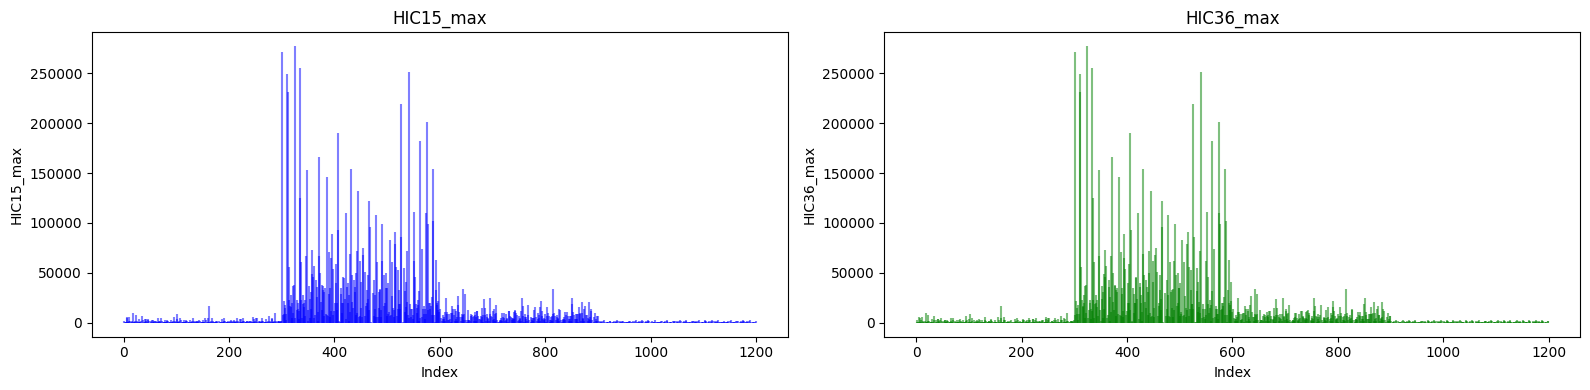

In [13]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Vertical lines plot for 'HIC15_max'
axes[0].vlines(df.index, ymin=0, ymax=df['HIC15_max'], color='blue', alpha=0.5)
axes[0].set_title('HIC15_max')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('HIC15_max')

# Vertical lines plot for 'HIC36_max'
axes[1].vlines(df.index, ymin=0, ymax=df['HIC36_max'], color='green', alpha=0.5)
axes[1].set_title('HIC36_max')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('HIC36_max')

# Adjust layout
plt.tight_layout()
plt.show()

### HIC15_max per bin

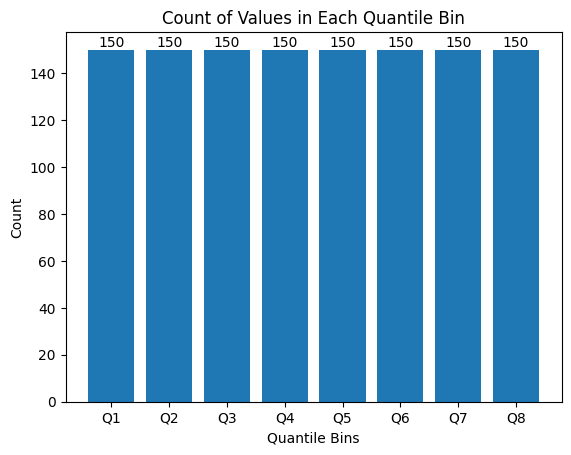

In [15]:
# Count the occurrences of each bin
bin_counts = df['HIC15_max_binned'].value_counts().sort_index()

# Create the bar plot
fig, ax = plt.subplots()
bars = ax.bar(bin_counts.index, bin_counts.values)

# Add labels on the bars
ax.bar_label(bars)

# Add labels and title for clarity
plt.xlabel('Quantile Bins')
plt.ylabel('Count')
plt.title('Count of Values in Each Quantile Bin')

# Display the plot
plt.show()

### Show paths of highest and lowest entries per bin

In [16]:
import os

top_bottom_paths = {}
n = 5

for bin_value, group in df.groupby('HIC15_max_binned'):
    # Sort group by HIC15_max
    sorted_group = group.sort_values(by='HIC15_max')
        
    # Get top and bottom n paths
    top_paths = sorted_group.tail(n)[['Path', 'HIC15_max']]
    bottom_paths = sorted_group.head(n)[['Path', 'HIC15_max']]
    
    # Extract filenames from paths
    top_paths['Filename'] = top_paths['Path'].apply(os.path.basename)
    bottom_paths['Filename'] = bottom_paths['Path'].apply(os.path.basename)
        
    top_bottom_paths[bin_value] = {
        'top': top_paths,
        'bottom': bottom_paths
    }

# Display the paths
for bin_value, paths in top_bottom_paths.items():
    print(f"Quantile Bin: {bin_value}")
    print("Bottom 5 filenames:")
    print(paths['bottom'][['Filename', 'HIC15_max']])
    print("Top 5 filenames:")
    print(paths['top'][['Filename', 'HIC15_max']])
    print("\n")


Quantile Bin: Q1
Bottom 5 filenames:
                                              Filename  HIC15_max
1191   Type=SUV_Vel=80_tra=400_rot=180_pos=initial.txt        0.0
975   Type=SUV_Vel=20_tra=-400_rot=180_pos=initial.txt        0.0
147      Type=FCR_Vel=40_tra=0_rot=180_pos=initial.txt        0.0
154       Type=FCR_Vel=40_tra=0_rot=60_pos=initial.txt        0.0
179     Type=FCR_Vel=40_tra=400_rot=90_pos=initial.txt        0.0
Top 5 filenames:
                                             Filename  HIC15_max
171   Type=FCR_Vel=40_tra=400_rot=180_pos=initial.txt    112.677
986     Type=SUV_Vel=20_tra=0_rot=150_pos=initial.txt    112.730
1112     Type=SUV_Vel=60_tra=0_rot=30_pos=initial.txt    113.395
291   Type=FCR_Vel=80_tra=400_rot=180_pos=initial.txt    113.517
72     Type=FCR_Vel=20_tra=-400_rot=0_pos=initial.txt    113.793


Quantile Bin: Q2
Bottom 5 filenames:
                                             Filename  HIC15_max
327    Type=MPV_Vel=100_tra=0_rot=180_pos=initial.txt   

C:\Users\geork\AppData\Local\Temp\ipykernel_13580\1368391007.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_value, group in df.groupby('HIC15_max_binned'):


### Head XYZ Acceleration

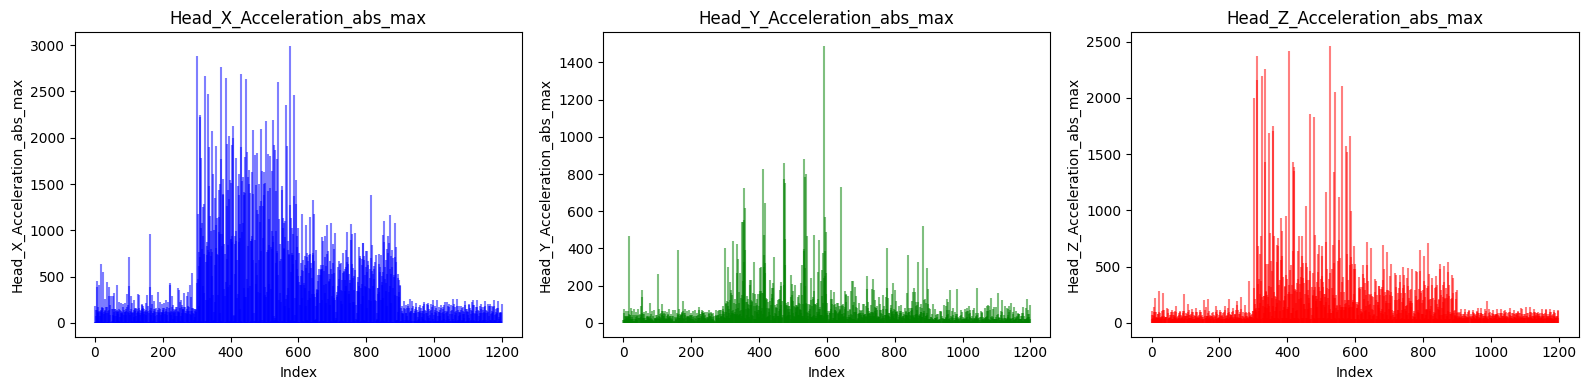

In [17]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

# Vertical lines plot for 'HIC15_max'
axes[0].vlines(df.index, ymin=0, ymax=df['Head_X_Acceleration_abs_max'], color='blue', alpha=0.5)
axes[0].set_title('Head_X_Acceleration_abs_max')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Head_X_Acceleration_abs_max')

# Vertical lines plot for 'HIC36_max'
axes[1].vlines(df.index, ymin=0, ymax=df['Head_Y_Acceleration_abs_max'], color='green', alpha=0.5)
axes[1].set_title('Head_Y_Acceleration_abs_max')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Head_Y_Acceleration_abs_max')

# Vertical lines plot for 'HIC36_max'
axes[2].vlines(df.index, ymin=0, ymax=df['Head_Z_Acceleration_abs_max'], color='red', alpha=0.5)
axes[2].set_title('Head_Z_Acceleration_abs_max')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Head_Z_Acceleration_abs_max')

# Adjust layout
plt.tight_layout()
plt.show()

### Brain Injury Damage(BrIC) - Chest_Resultant_Acceleration_max - Chest_Resultant_Acceleration_CLIP3ms_max

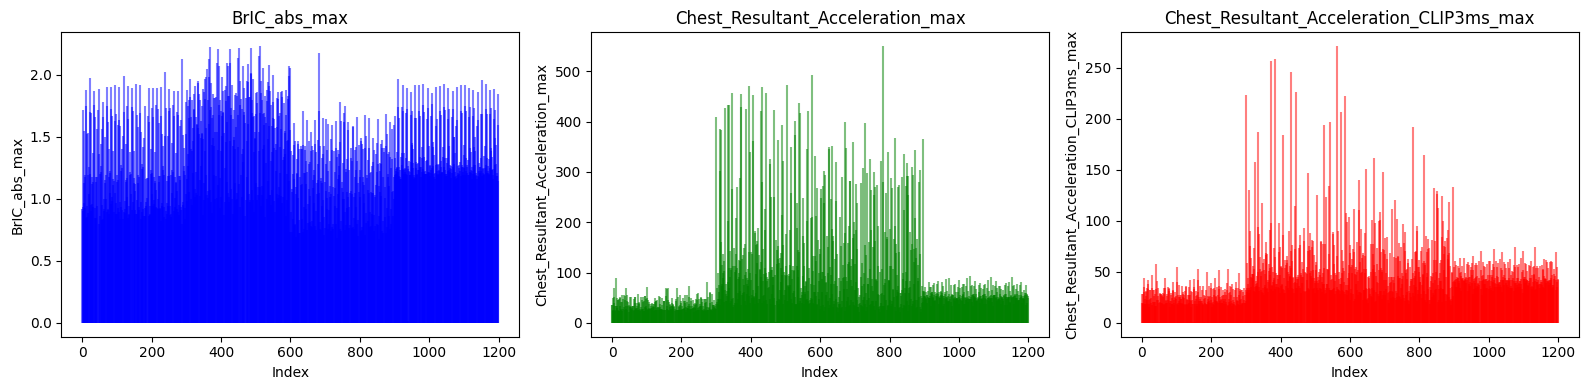

In [18]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

# Vertical lines plot for 'HIC15_max'
axes[0].vlines(df.index, ymin=0, ymax=df['BrIC_abs_max'], color='blue', alpha=0.5)
axes[0].set_title('BrIC_abs_max')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('BrIC_abs_max')

# Vertical lines plot for 'HIC36_max'
axes[1].vlines(df.index, ymin=0, ymax=df['Chest_Resultant_Acceleration_max'], color='green', alpha=0.5)
axes[1].set_title('Chest_Resultant_Acceleration_max')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Chest_Resultant_Acceleration_max')

# Vertical lines plot for 'HIC36_max'
axes[2].vlines(df.index, ymin=0, ymax=df['Chest_Resultant_Acceleration_CLIP3ms_max'], color='red', alpha=0.5)
axes[2].set_title('Chest_Resultant_Acceleration_CLIP3ms_max')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Chest_Resultant_Acceleration_CLIP3ms_max')

# Adjust layout
plt.tight_layout()
plt.show()

## Binary classification: HIC15_max

### Convert HIC15 to binary value

Entries over the threshold: 791
Entries under the threshold: 409


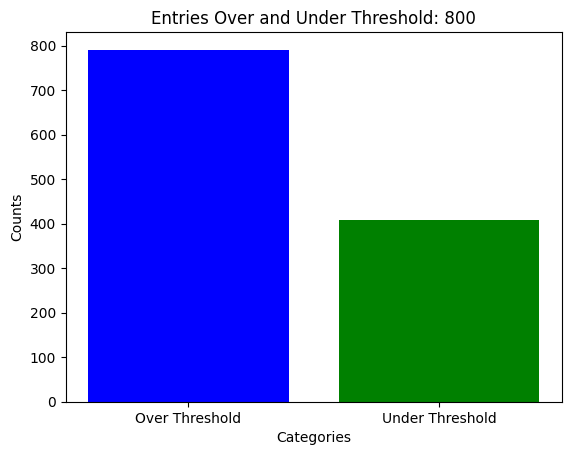

In [19]:
threshold = 800
over_thres  = (df["HIC15_max"] > threshold).sum()
under_thres = (df["HIC15_max"] <= threshold).sum()

print("Entries over the threshold:", over_thres)
print("Entries under the threshold:", under_thres)

# Data for the bar chart
categories = ['Over Threshold', 'Under Threshold']
counts = [over_thres, under_thres]

# Create the bar chart
plt.bar(categories, counts, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Entries Over and Under Threshold: 800')

# Show the plot
plt.show()

In [20]:
print(df.dtypes)

Id                                             int64
Path                                          object
CarProfile                                    object
Velocity                                       int64
Translation                                    int32
Rotation                                       int32
HIC15_max                                    float64
HIC36_max                                    float64
Head_Z_Acceleration_abs_max                  float64
Head_X_Acceleration_abs_max                  float64
Head_Y_Acceleration_abs_max                  float64
BrIC_abs_max                                 float64
Chest_Resultant_Acceleration_max             float64
Chest_Resultant_Acceleration_CLIP3ms_max     float64
HIC15_max_binned                            category
Front_Height                                   int64
Hood_Front_Width                               int64
Hood_Back_Width                                int64
Hood_Length                                   

### Preprocessing for classification

In [21]:
to_remove_features = ["Id", "Path",
                      "HIC36_max", 
                      "Head_Z_Acceleration_abs_max", "Head_X_Acceleration_abs_max", "Head_Y_Acceleration_abs_max",
                      "BrIC_abs_max", 
                      "Chest_Resultant_Acceleration_max", "Chest_Resultant_Acceleration_CLIP3ms_max", "HIC15_max_binned"]
# Remove the unwanted columns
dfn = df.drop(columns=to_remove_features)

# Create a new target column for the classification
dfn["HIC15_over_800"] = (dfn["HIC15_max"] > 800).astype(int)
dfn = dfn.drop(columns=["HIC15_max"])

# Use pd.get_dummies for encoding
dfn = pd.get_dummies(dfn, columns=["CarProfile"], drop_first=False)
print(dfn.dtypes)
print(dfn.head())


Velocity               int64
Translation            int32
Rotation               int32
Front_Height           int64
Hood_Front_Width       int64
Hood_Back_Width        int64
Hood_Length            int64
Hood_Angle           float64
Windscreen_Length      int64
Windscreen_Angle       int64
HIC15_over_800         int32
CarProfile_FCR          bool
CarProfile_MPV          bool
CarProfile_RDS          bool
CarProfile_SUV          bool
dtype: object
   Velocity  Translation  Rotation  Front_Height  Hood_Front_Width  \
0       100         -200         0           770              1160   
1       100         -200       120           770              1160   
2       100         -200       150           770              1160   
3       100         -200       180           770              1160   
4       100         -200       210           770              1160   

   Hood_Back_Width  Hood_Length  Hood_Angle  Windscreen_Length  \
0             1460         1070        11.0                816  

In [22]:
# Split the data into features and target
X = dfn.drop(columns=["HIC15_over_800"])
y = dfn["HIC15_over_800"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Print value counts for the last four columns
columns_to_check = ['CarProfile_FCR', 'CarProfile_MPV', 'CarProfile_RDS', 'CarProfile_SUV']
for column in columns_to_check:
    print(f"Value counts for {column}:")
    print(X_test[column].value_counts())
    print()
# Step 6: Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Value counts for CarProfile_FCR:
CarProfile_FCR
False    178
True      62
Name: count, dtype: int64

Value counts for CarProfile_MPV:
CarProfile_MPV
False    180
True      60
Name: count, dtype: int64

Value counts for CarProfile_RDS:
CarProfile_RDS
False    180
True      60
Name: count, dtype: int64

Value counts for CarProfile_SUV:
CarProfile_SUV
False    182
True      58
Name: count, dtype: int64



### Binary classification

c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6528 - loss: 0.6103 - val_accuracy: 0.7333 - val_loss: 0.5306
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6669 - loss: 0.5778 - val_accuracy: 0.7167 - val_loss: 0.5241
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6599 - loss: 0.5897 - val_accuracy: 0.7083 - val_loss: 0.5189
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6944 - loss: 0.5371 - val_accuracy: 0.7292 - val_loss: 0.5342
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6798 - loss: 0.5733 - val_accuracy: 0.7417 - val_loss: 0.5223
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6850 - loss: 0.5628 - val_accuracy: 0.7167 - val_loss: 0.5209
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6792 - loss: 0.5692 - val_accuracy: 0.7083 - val_loss: 0.5393
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7132 - loss: 0.5259 - val_accuracy: 0.7333 - val_loss:

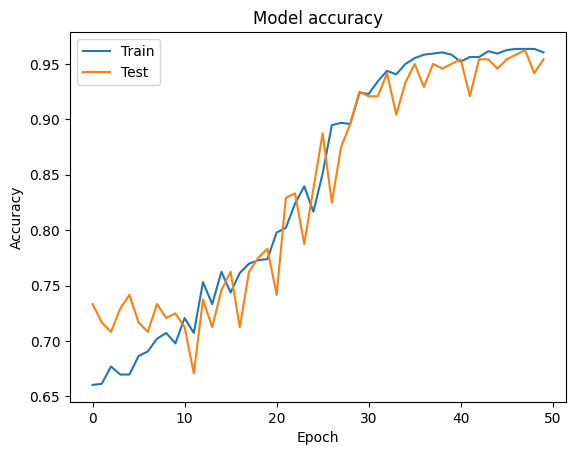

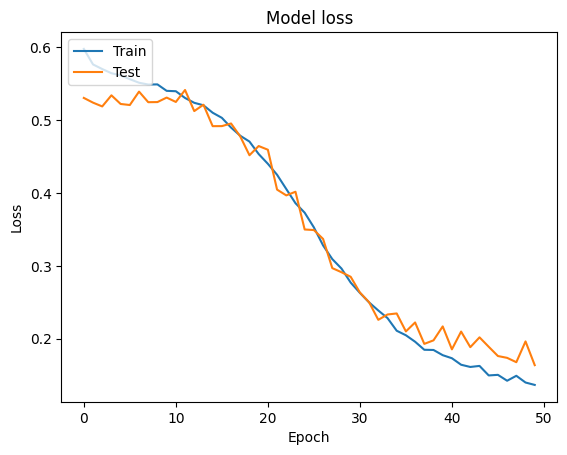

In [23]:

# Step 7: Build and train the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## HIC15 regression

### Preprocessing

In [24]:
to_remove_features = ["Id", "Path",
                      "HIC36_max", 
                      "Head_Z_Acceleration_abs_max", "Head_X_Acceleration_abs_max", "Head_Y_Acceleration_abs_max",
                      "BrIC_abs_max", 
                      "Chest_Resultant_Acceleration_max", "Chest_Resultant_Acceleration_CLIP3ms_max", "HIC15_max_binned"]
# Remove the unwanted columns
dfn_regr = df.drop(columns=to_remove_features)

# Use pd.get_dummies for encoding
dfn_regr = pd.get_dummies(dfn_regr, columns=["CarProfile"], drop_first=False)
print(dfn_regr.dtypes)
print(dfn_regr.head())


Velocity               int64
Translation            int32
Rotation               int32
HIC15_max            float64
Front_Height           int64
Hood_Front_Width       int64
Hood_Back_Width        int64
Hood_Length            int64
Hood_Angle           float64
Windscreen_Length      int64
Windscreen_Angle       int64
CarProfile_FCR          bool
CarProfile_MPV          bool
CarProfile_RDS          bool
CarProfile_SUV          bool
dtype: object
   Velocity  Translation  Rotation  HIC15_max  Front_Height  Hood_Front_Width  \
0       100         -200         0     86.843           770              1160   
1       100         -200       120   2361.697           770              1160   
2       100         -200       150    573.455           770              1160   
3       100         -200       180     84.702           770              1160   
4       100         -200       210    592.965           770              1160   

   Hood_Back_Width  Hood_Length  Hood_Angle  Windscreen_Length  

In [25]:
# Split the data into features and target
X = dfn_regr.drop(columns=["HIC15_max"])
y = dfn_regr["HIC15_max"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Print value counts for the last four columns
columns_to_check = ['CarProfile_FCR', 'CarProfile_MPV', 'CarProfile_RDS', 'CarProfile_SUV']
for column in columns_to_check:
    print(f"Value counts for {column}:")
    print(X_test[column].value_counts())
    print()
# Step 6: Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Value counts for CarProfile_FCR:
CarProfile_FCR
False    178
True      62
Name: count, dtype: int64

Value counts for CarProfile_MPV:
CarProfile_MPV
False    180
True      60
Name: count, dtype: int64

Value counts for CarProfile_RDS:
CarProfile_RDS
False    180
True      60
Name: count, dtype: int64

Value counts for CarProfile_SUV:
CarProfile_SUV
False    182
True      58
Name: count, dtype: int64



### Regression attempt #1

In [26]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test MAE: {mae}')

# Make predictions
predictions = model.predict(X_test)

Epoch 1/100


c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 862592960.0000 - mae: 10143.3584 - val_loss: 827996224.0000 - val_mae: 10702.3018
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1056870208.0000 - mae: 11220.3320 - val_loss: 826596544.0000 - val_mae: 10663.8125
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1206955520.0000 - mae: 11758.5225 - val_loss: 820497664.0000 - val_mae: 10553.9658
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1195288448.0000 - mae: 11043.7158 - val_loss: 803713344.0000 - val_mae: 10328.1152
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 952883776.0000 - mae: 10514.7178 - val_loss: 765850432.0000 - val_mae: 9867.1533
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 895250112.0000 - mae: 9978.1611 - val_loss: 702911808.0000 - val_mae: 9224.7432
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 953387520.0000 - mae: 9229.4131 - val_loss: 621929600.0000 - val_mae: 8813.9961
Epoch 8/100
24/24 ━━━━━━━━

### Regression attempt #2

c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1207211520.0000 - mae: 11954.6230 - val_loss: 828087296.0000 - val_mae: 10705.1650
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1269207680.0000 - mae: 11958.8643 - val_loss: 827421888.0000 - val_mae: 10685.9268
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1422653056.0000 - mae: 12382.3467 - val_loss: 824806400.0000 - val_mae: 10627.4619
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1016036992.0000 - mae: 10416.5732 - val_loss: 816694208.0000 - val_mae: 10505.3828
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1409531392.0000 - mae: 12120.2217 - val_loss: 797930496.0000 - val_mae: 10263.4814
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 725320000.0000 - mae: 9395.8867 - val_loss: 763659264.0000 - val_mae: 9847.1123
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 678749376.0000 - mae: 8793.3662 - val_loss: 709502208.0000 - val_mae: 9293.5000
Epoch 8/100

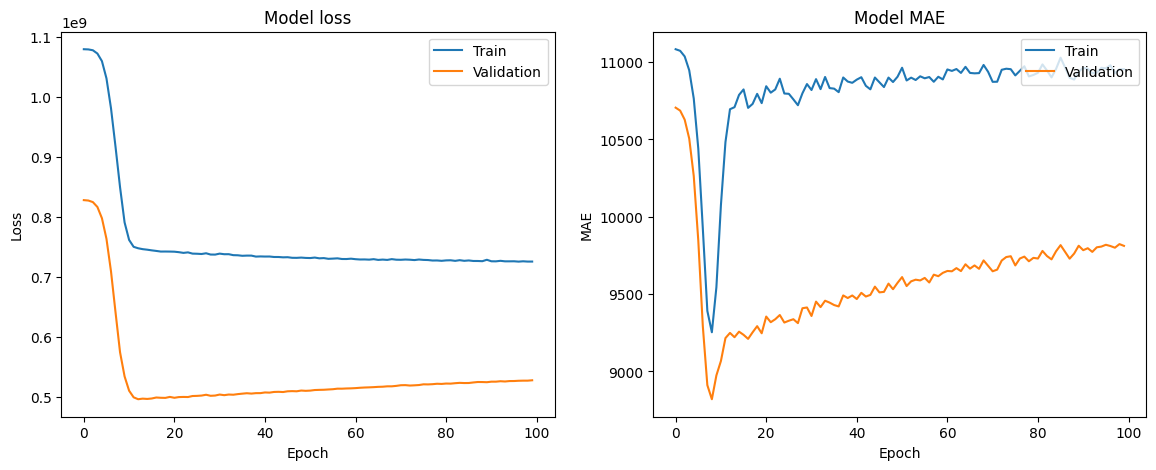

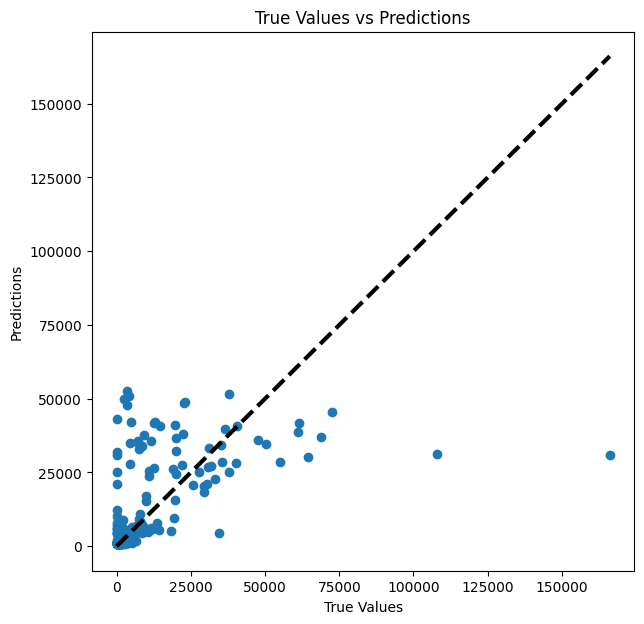

In [27]:
# Build the model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
#history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1, callbacks=[early_stop])
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1)


# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test MSE: {loss}, Test MAE: {mae}')

# Make predictions
predictions = model.predict(X_test)

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

# Scatter plot of predictions vs true values
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

Our model's performance, as indicated by the high loss and MAE values, suggests that it may be underfitting or the dataset may have issues that need addressing. Here are several strategies to improve your model:

1. Data Preprocessing
- Feature Engineering: Create new features that might better represent the underlying data patterns.
- Scaling: Ensure all features are properly scaled.
- Outlier Removal: Remove or cap outliers in the dataset.
- Feature Selection: Ensure only the most relevant features are included.
2. Model Architecture
- Increase Complexity: Add more layers or neurons to your model.
- Activation Functions: Try different activation functions such as LeakyReLU or ELU.
- Regularization: Adjust regularization parameters.
3. Hyperparameter Tuning
- Use tools like GridSearchCV or RandomizedSearchCV to find the best hyperparameters.
4. Training Techniques
- Early Stopping: Use EarlyStopping with a more patient threshold.
- Learning Rate Scheduling: Adjust learning rates dynamically during training.
- Batch Normalization: Add batch normalization layers.
5. Visualizing and Debugging
- Residual Analysis: Analyze the residuals to understand model errors.
- Cross-Validation: Use cross-validation to ensure robustness.


### Regression attempt #3

Changes and Additions:
- Batch Normalization: Added after each Dense layer to help stabilize and speed up training.
- Dropout: Added to prevent overfitting.
- Early Stopping: More patient with a restore best weights option.
- Learning Rate Scheduling: Reduce learning rate if validation loss plateaus.


Epoch 1/200


c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 1152025472.0000 - mae: 11249.3711 - val_loss: 828216128.0000 - val_mae: 10710.3662 - learning_rate: 0.0010
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1239593216.0000 - mae: 11058.6006 - val_loss: 828180288.0000 - val_mae: 10710.0312 - learning_rate: 0.0010
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1204203264.0000 - mae: 11853.3408 - val_loss: 828144960.0000 - val_mae: 10709.7744 - learning_rate: 0.0010
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1139699072.0000 - mae: 10759.1943 - val_loss: 828114688.0000 - val_mae: 10709.6182 - learning_rate: 0.0010
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 825048832.0000 - mae: 9023.4209 - val_loss: 828086464.0000 - val_mae: 10709.5596 - learning_rate: 0.0010
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 988310080.0000 - mae: 10712.6494 - val_loss: 828046336.0000 - val_mae: 10709.7871 - learning_rate: 0.0010
Epoch 7/200
24/2

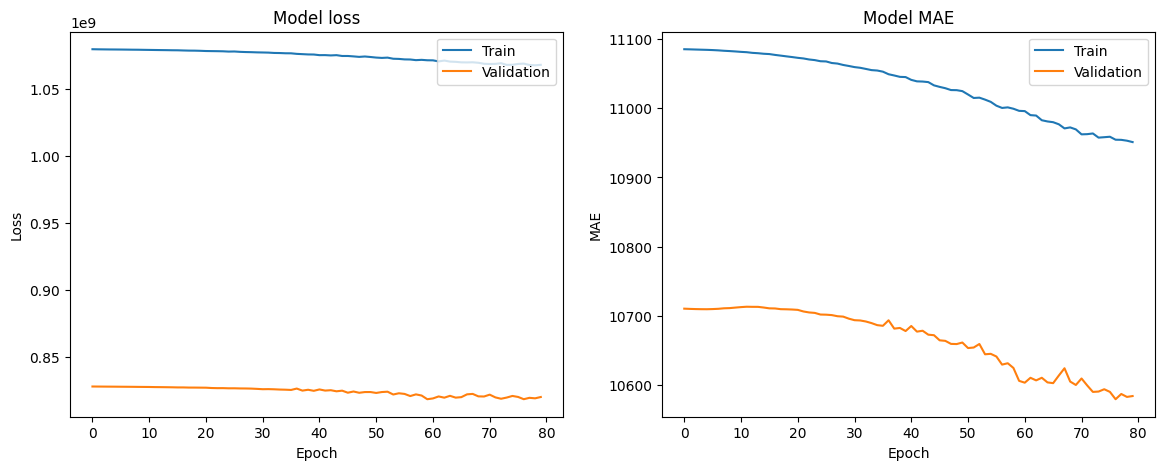

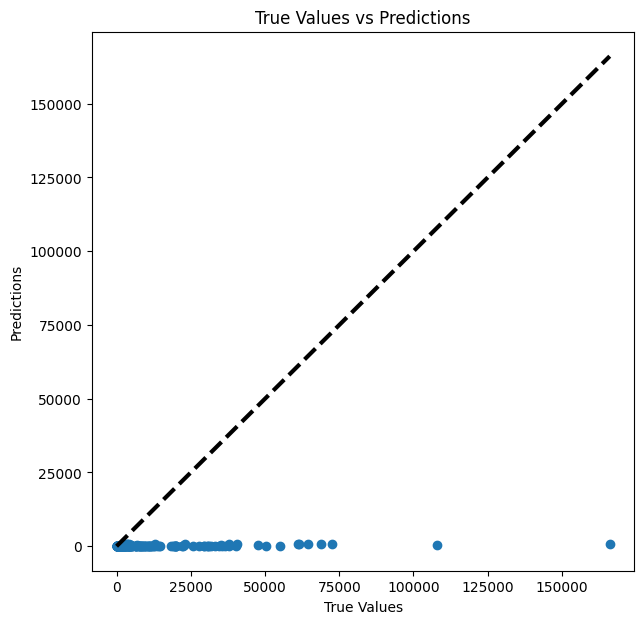

In [28]:
# Build the model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=32, verbose=1, callbacks=[early_stop, reduce_lr])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test MSE: {loss}, Test MAE: {mae}')

# Make predictions
predictions = model.predict(X_test)

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

# Scatter plot of predictions vs true values
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()


## Transforming a Regression Problem into a Balanced Classification Task using Quantile Binning

Splitting the target variable HIC15_max into bins with an approximately equal number of items is a method called quantile binning. <br>
This ensures that each bin contains roughly the same number of samples, regardless of the actual value distribution.<br> This method can help address issues with skewed distributions and provide more balanced classes for classification tasks.

Here's how you can implement quantile binning in Python:

Use pd.qcut to create quantile bins.
Update the target variable and re-split the dataset.
Proceed with training a classification model.<br>
Here's a step-by-step guide and the corresponding code:

Step-by-Step Guide
Create Quantile Bins:

Use pd.qcut to split HIC15_max into a specified number of quantiles, ensuring each bin has an approximately equal number of samples.<br>
Modify the Target Variable:

Replace the continuous HIC15_max values with the new quantile bins.
Split the Data and Train a Classification Model:

Split the data into training and testing sets.
Standardize the features if necessary.
Train a classification model and evaluate its performance.

Notes:
Quantile Bins: The pd.qcut function automatically determines the bin edges so that each bin contains approximately the same number of observations. <br>Adjust number_of_bins according to your needs.
Labels: Assign meaningful labels to the bins, such as Q1, Q2, etc.
Model Selection and Evaluation: Different models might perform better on this transformed problem. Experiment with various classifiers and hyperparameters.
By using quantile binning, you ensure that your classes are balanced, which can lead to better performance and more reliable evaluation metrics for your classification models.

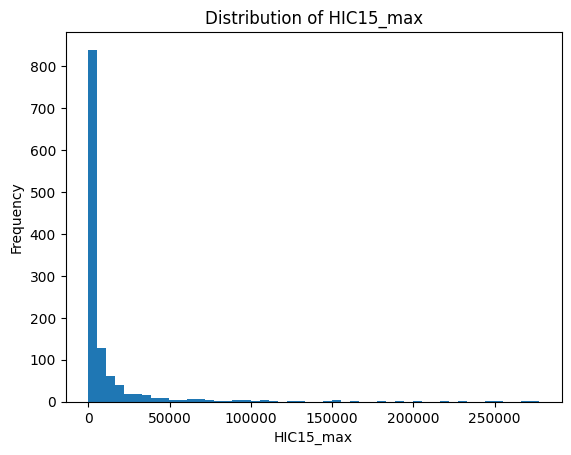

Ranges for each quantile bin:
Q1: 0.0 to 113.893625
Q2: 113.893625 to 444.45125
Q3: 444.45125 to 988.397375
Q4: 988.397375 to 1826.8964999999998
Q5: 1826.8964999999998 to 3490.965375
Q6: 3490.965375 to 7791.7429999999995
Q7: 7791.7429999999995 to 19452.69675
Q8: 19452.69675 to 277304.682
0       Q1
1       Q5
2       Q3
3       Q1
4       Q3
        ..
1195    Q3
1196    Q2
1197    Q2
1198    Q4
1199    Q5
Name: HIC15_max, Length: 1200, dtype: category
Categories (8, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' < 'Q5' < 'Q6' < 'Q7' < 'Q8']
[[16  3  2  0  1  0  0  1]
 [ 2 18  4  0  1  1  0  0]
 [ 3  3 17  7  3  0  0  0]
 [ 2  1  2 12  8  5  2  0]
 [ 1  0  0  9 14  6  2  1]
 [ 1  0  0  3  2 11  9  3]
 [ 0  0  0  0  0  5 19  4]
 [ 0  0  0  0  0  1 11 24]]
              precision    recall  f1-score   support

          Q1       0.64      0.70      0.67        23
          Q2       0.72      0.69      0.71        26
          Q3       0.68      0.52      0.59        33
          Q4       0.39      

In [29]:
# Assuming dfn_regr is your DataFrame
# Check the distribution of the target variable
plt.hist(dfn_regr['HIC15_max'], bins=50)
plt.xlabel('HIC15_max')
plt.ylabel('Frequency')
plt.title('Distribution of HIC15_max')
plt.show()

# Create quantile bins
number_of_bins = 8  # You can adjust the number of bins as needed
y_binned, bin_edges = pd.qcut(dfn_regr['HIC15_max'], q=number_of_bins, labels=[f'Q{i+1}' for i in range(number_of_bins)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Replace the continuous target variable with the new binned variable
X = dfn_regr.drop(columns=["HIC15_max"])
y = y_binned
print(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a classification model
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


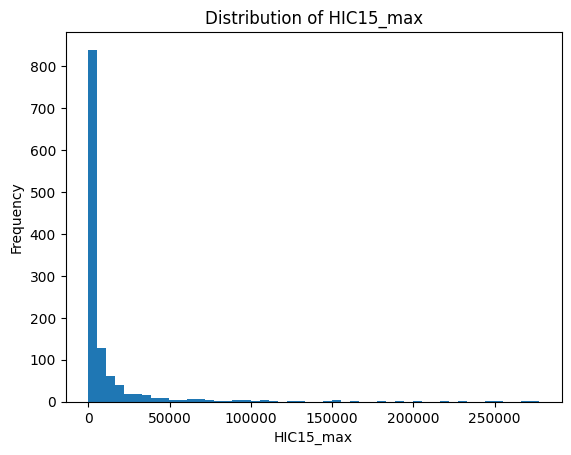

Ranges for each quantile bin:
Q1: 0.0 to 773.7126666666662
Q2: 773.7126666666662 to 4581.242999999994
Q3: 4581.242999999994 to 277304.682
0       Q1
1       Q2
2       Q1
3       Q1
4       Q1
        ..
1195    Q1
1196    Q1
1197    Q1
1198    Q2
1199    Q2
Name: HIC15_max, Length: 1200, dtype: category
Categories (3, object): ['Q1' < 'Q2' < 'Q3']


c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3652 - loss: 1.2340 - val_accuracy: 0.6042 - val_loss: 0.9388
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4569 - loss: 1.0513 - val_accuracy: 0.6083 - val_loss: 0.8696
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4780 - loss: 1.0015 - val_accuracy: 0.6083 - val_loss: 0.8280
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5300 - loss: 0.9231 - val_accuracy: 0.6042 - val_loss: 0.8033
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5063 - loss: 0.9136 - val_accuracy: 0.5875 - val_loss: 0.7867
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5214 - loss: 0.9034 - val_accuracy: 0.5875 - val_loss: 0.7792
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5845 - loss: 0.8679 - val_accuracy: 0.6208 - val_loss: 0.7802
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5667 - loss: 0.8391 - val_accuracy: 0.5958 - val_loss

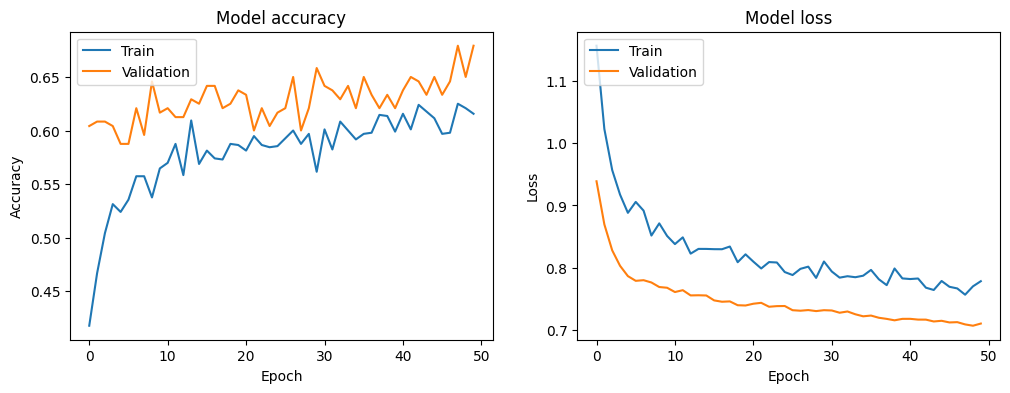

In [30]:
# Assuming dfn_regr is your DataFrame
# Check the distribution of the target variable
plt.hist(dfn_regr['HIC15_max'], bins=50)
plt.xlabel('HIC15_max')
plt.ylabel('Frequency')
plt.title('Distribution of HIC15_max')
plt.show()

# Create quantile bins
number_of_bins = 3  # You can adjust the number of bins as needed
y_binned, bin_edges = pd.qcut(dfn_regr['HIC15_max'], q=number_of_bins, labels=[f'Q{i+1}' for i in range(number_of_bins)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Replace the continuous target variable with the new binned variable
X = dfn_regr.drop(columns=["HIC15_max"])
y = y_binned
print(y)

# Convert categorical labels to numerical values
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

# Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert target variable to categorical
y_train_cat = to_categorical(y_train, num_classes=number_of_bins)
y_test_cat = to_categorical(y_test, num_classes=number_of_bins)

# Define the deep learning model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(number_of_bins, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test, y_test_cat))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict and evaluate
y_pred_cat = model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


### Model with hyperparameter tuning

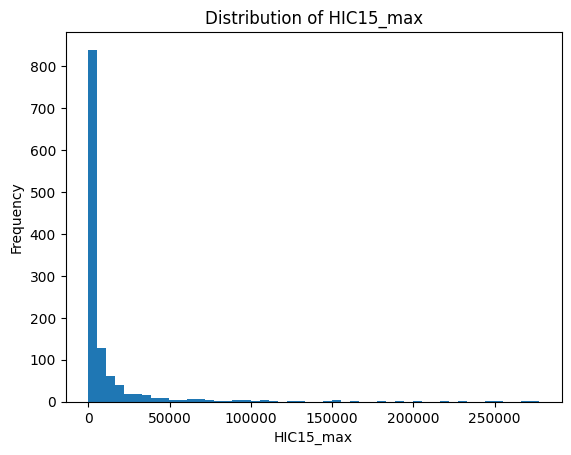

Ranges for each quantile bin:
Q1: 0.0 to 113.893625
Q2: 113.893625 to 444.45125
Q3: 444.45125 to 988.397375
Q4: 988.397375 to 1826.8964999999998
Q5: 1826.8964999999998 to 3490.965375
Q6: 3490.965375 to 7791.7429999999995
Q7: 7791.7429999999995 to 19452.69675
Q8: 19452.69675 to 277304.682
Epoch 1/1000


c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1728 - loss: 2.7940 - val_accuracy: 0.3375 - val_loss: 1.8854
Epoch 2/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2770 - loss: 2.3262 - val_accuracy: 0.3542 - val_loss: 1.8064
Epoch 3/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2479 - loss: 2.2619 - val_accuracy: 0.3333 - val_loss: 1.7778
Epoch 4/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2844 - loss: 2.0587 - val_accuracy: 0.3083 - val_loss: 1.7437
Epoch 5/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2787 - loss: 2.0516 - val_accuracy: 0.3333 - val_loss: 1.7111
Epoch 6/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2695 - loss: 2.0578 - val_accuracy: 0.3667 - val_loss: 1.6746
Epoch 7/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3069 - loss: 1.9063 - val_accuracy: 0.3750 - val_loss: 1.6502
Epoch 8/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2997 - loss: 1.8519 - val_accuracy: 0.3542 - val_l

KeyboardInterrupt: 

In [31]:
# Assuming dfn_regr is your DataFrame
# Check the distribution of the target variable
plt.hist(dfn_regr['HIC15_max'], bins=50)
plt.xlabel('HIC15_max')
plt.ylabel('Frequency')
plt.title('Distribution of HIC15_max')
plt.show()

# Create quantile bins
number_of_bins = 8  # You can adjust the number of bins as needed
y_binned, bin_edges = pd.qcut(dfn_regr['HIC15_max'], q=number_of_bins, labels=[f'Q{i+1}' for i in range(number_of_bins)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Replace the continuous target variable with the new binned variable
X = dfn_regr.drop(columns=["HIC15_max"])
y = y_binned

# Convert categorical labels to numerical values
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

# Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert target variable to categorical
y_train_cat = to_categorical(y_train, num_classes=number_of_bins)
y_test_cat = to_categorical(y_test, num_classes=number_of_bins)

# Define the deep learning model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(number_of_bins, activation='softmax'))

# Compile the model with a different learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=1000, batch_size=32, validation_data=(X_test, y_test_cat))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict and evaluate
y_pred_cat = model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


### Regularization with L2

In [ ]:
# Assuming dfn_regr is your DataFrame
# Check the distribution of the target variable
plt.hist(dfn_regr['HIC15_max'], bins=50)
plt.xlabel('HIC15_max')
plt.ylabel('Frequency')
plt.title('Distribution of HIC15_max')
plt.show()

# Create quantile bins
number_of_bins = 8  # You can adjust the number of bins as needed
y_binned, bin_edges = pd.qcut(dfn_regr['HIC15_max'], q=number_of_bins, labels=[f'Q{i+1}' for i in range(number_of_bins)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Replace the continuous target variable with the new binned variable
X = dfn_regr.drop(columns=["HIC15_max"])
y = y_binned

# Convert categorical labels to numerical values
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

# Standardize/normalize the data if necessary
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert target variable to categorical
y_train_cat = to_categorical(y_train, num_classes=number_of_bins)
y_test_cat = to_categorical(y_test, num_classes=number_of_bins)

# Define the deep learning model with L2 regularization
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(number_of_bins, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=100, batch_size=32, validation_data=(X_test, y_test_cat))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict and evaluate
y_pred_cat = model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
